# ImageSegmentNet-v2
* Revisit ImageSegmentNet but implement with Segment layers

## Summary
* This code demonstrated that a model made up of layered segments can learn an image if the model has segments mapping 1:1 with rows in the image. The values in the cells are replaced by row number where a pixel is not zero. Each segment layer have width/2 segments.
* We can do the same columnwise.
* The loss continuously decreases ans was 0.0043 after 50,000 training steps (stated at 0.05)

## Observations
* Created a model that has 1 segment per row of the image but only width/2 segments
* Model were trained with image values replaced by row number and column number
* Both models train, visually column number looked better (similar losses start at 0.05 reduced to 0.006)
* Next step is to try grayscale image directly
* grayscale started with 2x loss (.91) but trained equally well to (.06) but image looks bad. Clearly thr above methods are better.
* Trying bw_image : started at 0.18 loss traine to .018 but is not as clean (better than gray scale)

# Initialization

In [1]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F

from segment import Segment

In [2]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using mps device


In [3]:
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# MNIST dataset

In [4]:
from torchvision import datasets, transforms

flatten_by_row_transform = transforms.Lambda(lambda x: x.flatten())
flatten_by_col_transform = transforms.Lambda(lambda x: x.permute(0,2,1).flatten())

train_transform = transforms.Compose([
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    #transforms.RandomRotation(15), #only during training
    transforms.Normalize([0.5], [0.5])
])

test_transform = transforms.Compose([
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize([0.5], [0.5])
])

train_set = datasets.MNIST('data', train=True, download=False, transform=train_transform)
test_set = datasets.MNIST('data', train=False, download=False, transform=test_transform)
print(len(train_set), len(test_set))
print(train_set[0][0].shape, test_set[0][0].shape)

60000 10000
torch.Size([1, 28, 28]) torch.Size([1, 28, 28])


# Data Prep

In [5]:
def prepare_image(image):
    # convert image to black and white
    test_image = image.squeeze().numpy() # remove channel dimension
    limit = test_image.mean()
    bw_array  = torch.tensor(np.where(test_image < limit, 0, 1))

    height = bw_array.shape[0]
    width = bw_array.shape[1]
    maxval = height + 1
    yrange = torch.arange(1./maxval, 1., 1./maxval)
    #transpose yrange so it is [N,1]
    yrange = yrange.unsqueeze(1)
    yrange = yrange.permute(1,0) # experimenting with col numbers instead of row numbers
    print(yrange.shape)
    #create array that contains y pos values instead of 1
    yval_array = yrange*bw_array
    return yval_array

torch.Size([1, 28])
torch.Size([28, 28])


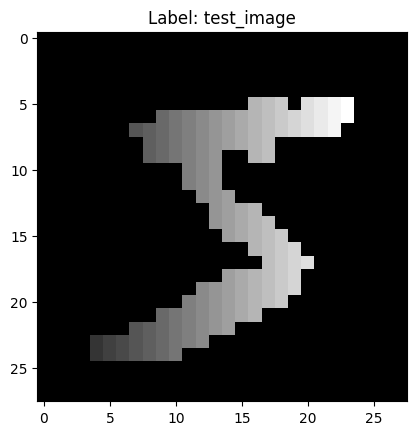

In [6]:
test_image = train_set[0][0]
test_image = prepare_image(test_image) 
print(test_image.shape)

plt.imshow(test_image.squeeze().numpy(), cmap='gray')
plt.title(f"Label: test_image")
plt.show()

In [7]:
class ImageSegmentNet(nn.Module):
    def __init__(self, image_height, image_width, num_segments):
        super(ImageSegmentNet, self).__init__()
        self.image_height = image_height
        self.image_width = image_width
        self.segments = nn.ModuleList([Segment(1, 1, num_segments) for i in range(image_height)])
        self.x_in = (torch.arange(image_width)/image_width).float()
        self.x_in = self.x_in.unsqueeze(-1) # make it a vertical tensor (N,1)

        for segment in self.segments:
            segment.custom_init(torch.Tensor([0]), torch.Tensor([1.0]))

    def forward(self, yact):
        # yact is the image 
        ypred = torch.zeros_like(yact)
        for i in range(self.image_height):
            yout = self.segments[i](self.x_in)
            ypred[i] = yout.squeeze()

        return ypred
        
        

In [8]:
# Init Model, Loss, Optimizer
model = ImageSegmentNet(28, 28, 14)
total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params}")

criterion = nn.MSELoss(reduction='mean')

lr=.0001
#optimizer only optimizes parameter that are sent to it in arg1
optimizer = torch.optim.AdamW(model.parameters(),
                               lr=lr, betas=(0.9, 0.999), eps=1e-8)

Total parameters: 840


In [9]:
# Train
max_step =50000
prev_loss = 1000000
target_loss = torch.zeros_like(test_image)
for i in range(max_step):
    image_pred = model.forward(test_image)
    loss = criterion(test_image, image_pred)
    if(math.isnan(loss)):
        print(f"nan loss at stei {i}")
        break
    if(loss > prev_loss*1.4):
        print(f"loss is increasing, stop training")
        break
    model.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()
    if (i%500 == 0):
        print(f"step {i}: loss: {loss}")
        prev_loss = loss
print(f"final step {i}: loss: {loss}")

step 0: loss: 0.05043649300932884
step 500: loss: 0.04128680005669594
step 1000: loss: 0.033654868602752686
step 1500: loss: 0.029899829998612404
step 2000: loss: 0.026703746989369392
step 2500: loss: 0.023343199864029884
step 3000: loss: 0.02056943066418171
step 3500: loss: 0.017742648720741272
step 4000: loss: 0.01543534267693758
step 4500: loss: 0.013503189198672771
step 5000: loss: 0.011879476718604565
step 5500: loss: 0.010539146140217781
step 6000: loss: 0.009490525349974632
step 6500: loss: 0.008597902953624725
step 7000: loss: 0.007964174263179302
step 7500: loss: 0.007255051285028458
step 8000: loss: 0.0066688829101622105
step 8500: loss: 0.00620749406516552
step 9000: loss: 0.006022937595844269
step 9500: loss: 0.005613586865365505
step 10000: loss: 0.005997916683554649
step 10500: loss: 0.005715570412576199
step 11000: loss: 0.005571987945586443
step 11500: loss: 0.005330977495759726
step 12000: loss: 0.005249051842838526
step 12500: loss: 0.005184064619243145
step 13000: lo

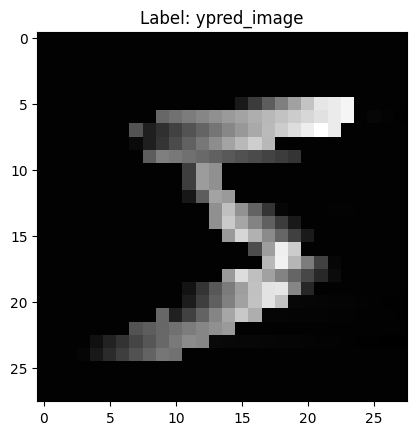

In [10]:
plt.imshow(image_pred.detach().numpy(), cmap='gray')
plt.title(f"Label: ypred_image")
plt.show()

In [11]:
for name, param in model.named_parameters():
    print(name, param.data.squeeze())


segments.0.x tensor([0.0000, 0.0679, 0.1358, 0.2038, 0.2717, 0.3393, 0.4076, 0.4753, 0.5433,
        0.6108, 0.6785, 0.7470, 0.8151, 0.8828, 0.9506])
segments.0.y tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
segments.1.x tensor([0.0000, 0.0679, 0.1358, 0.2038, 0.2717, 0.3393, 0.4076, 0.4753, 0.5433,
        0.6108, 0.6785, 0.7470, 0.8151, 0.8828, 0.9506])
segments.1.y tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
segments.2.x tensor([0.0000, 0.0679, 0.1358, 0.2038, 0.2717, 0.3393, 0.4076, 0.4753, 0.5433,
        0.6108, 0.6785, 0.7470, 0.8151, 0.8828, 0.9506])
segments.2.y tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
segments.3.x tensor([0.0000, 0.0679, 0.1358, 0.2038, 0.2717, 0.3393, 0.4076, 0.4753, 0.5433,
        0.6108, 0.6785, 0.7470, 0.8151, 0.8828, 0.9506])
segments.3.y tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
segments.4.x tensor([0.0000, 0.0679, 0.1358, 0.2038, 0.2717, 0.3393, 0.4